# Predicting Listing Prices on Airbnb with Spark and Scikit-Learn
More often than not, machine learning can help inform assumptions about customer behaviors and its applications vary based of business problems. Helping customers make better choices, building loyalty over time and making customers contagiously happy about your business to mention a few.

Let's deep dive into advanced analytics with Python and it's very popular library scikit-learn as we look to help visitors make better choices using the Inside Airbnb dataset for Armstadam

## Getting started
We'll start by predicting the listing price we expect the user to enter for a rental, based on the attributes of the listing. Being able to predict the price has several applications: we may advice the customer on pricing a unit (maybe display a warrning if the number chosen is too large or small), assist in how to advertise it, or inform our own analysis of the market for investment decision

## Exploring and Cleaning the Data
First, let's load the listing.csv dataset from our FileSystem into a Pandas dataframce. The data consists of approximately 1000 listings with over 90 columns, describing each listing in detail.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
LISTINGFILE = "/Users/olalekanelesin/data/airbnb/listings.csv"

cols = ['price',
        'accommodates',
        'bedrooms',
        'beds',
        'neighbourhood_cleansed',
        'room_type',
        'cancellation_policy',
        'instant_bookable',
        'reviews_per_month',
        'number_of_reviews',
        'availability_30',
        'review_scores_rating'
        ]

df = pd.read_csv(LISTINGFILE, usecols=cols)

In [3]:
df.head()

len(df.index)

13849

In [4]:
nb_count = Counter(df.neighbourhood_cleansed)
tdf = pd.DataFrame.from_dict(nb_count, orient='index').sort_values(by=0)

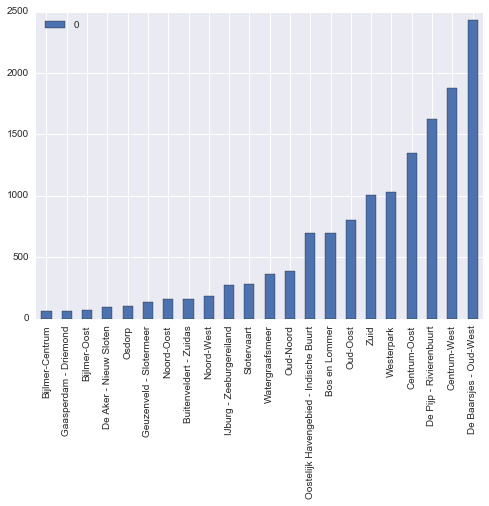

In [5]:
tdf.plot(kind='bar')

This data is coming in a little raw, so some cleaning is in order.

Particularly, the 'number_reviews' and 'reviews_per_month' fields look like they need some special processing to remove a large number of NaN values. Rather than discarding these outright, we set the value of 'reviews_per_month' to 0 where there is currently a NaN, because some quick analysis shows that this field is NaN only wherever 'number_of_reviews' is 0 (which makes some intuitive sense).

We also drop any entries that are obviously strange, such as listings with a value of 0 for bedrooms, beds, or price, then finally drop any remaining rows that have any NaN values. The resulting dataset contains 5246 entries, a subset of the original 10629.

In [7]:
bar_df = tdf
bar_df['neighbourhood_cleansed'] = tdf.index

In [8]:
len(df[(df.number_of_reviews == 0) & (pd.isnull(df.number_of_reviews) == False)
      & (pd.isnull(df.reviews_per_month) == False)].index)

0

In [9]:
len(df[(df.number_of_reviews != 0) & (pd.isnull(df.number_of_reviews) == False)
      &(pd.isnull(df.reviews_per_month) == True)].index)

0

In [10]:
# do some data cleaning

# first fill 'reviews_per_month' with 0 where there are no values
df['reviews_per_month'].fillna('0', inplace=True)

# Also drop rows with weird values
df = df[df.bedrooms != 0]
df = df[df.beds != 0]
df = df[df.price != 0]
df = df.dropna(axis=0)

len(df.index)

10623

In [11]:
df = df[df.bedrooms == 1]
len(df.index)

7047

The last bit of cleaning/filtering we'll do is convert the 'price' column to floating point, and drop all of the entries with more than one bedroom.

Approximately 70% of the entries in this file are for one bedroom listings (in large cities, especially San Francisco, this might be the norm), so it's the type of unit for which we have the most samples. By focusing our regression on a single type of unit, our model will be better as there is less to discover about the complex interactions with other features (such as whether the unit is shared, private, or has a private room). To make predictions for larger units, one way to go would be to develop separate models for each of the different sizes (2, 3, 4 bedrooms, etc.), or do some clustering to see if it is better to partition the data in some other way

In [12]:
df['price'] = df['price'].replace('[\$,)]', '', regex=True) \
                .replace("[()]", '-', regex=True).astype(float)

In [13]:
df.price.head(4)

0    95.0
1    60.0
2    45.0
3    35.0
Name: price, dtype: float64

We have a few columns that contain categorical variables. These are handled in slightly different ways depending on their possible values. The 'neighborhood_cleansed' field, in its raw form, is a string representing the name of the neighborhood. The regressors in scikit-learn will only accept numeric fields. For this type of variable we can use the get_dummies routine in Pandas to convert these to 'dummy' variables. This process is also known as "one hot" encoding, meaning we add a column for every possible value of the field. Each listing (row) contains a '1' in for its own neighborhood, else the column contains a '0' for that neighborhood.

We handle this in a similar way for the 'room_type' and 'cancellation_policy' fields.

For the instant_bookable field, we can represent it with a single column since it's a boolean value (it represents whether or not the unit can be booked instantly online without confirmation from the owner).

In [14]:
# get feature encoding for categorical variables
n_dummies = pd.get_dummies(df.neighbourhood_cleansed)
rt_dummies = pd.get_dummies(df.room_type)
xcl_dummies = pd.get_dummies(df.cancellation_policy)

# convert boolean column to a single boolean value indicating whether this listing has instant booking available
ib_dummies = pd.get_dummies(df.instant_bookable, prefix="instant")
ib_dummies = ib_dummies.drop('instant_f', axis=1)

# replace the old columns with our new one-hot encoded ones
alldata = pd.concat((df.drop(['neighbourhood_cleansed', \
    'room_type', 'cancellation_policy', 'instant_bookable'], axis=1), \
    n_dummies.astype(int), rt_dummies.astype(int), \
    xcl_dummies.astype(int), ib_dummies.astype(int)), \
    axis=1)
allcols = alldata.columns
alldata.head(5)

,accommodates,bedrooms,beds,price,availability_30,number_of_reviews,review_scores_rating,reviews_per_month,Bijlmer-Centrum,Bijlmer-Oost,...,Watergraafsmeer,Westerpark,Zuid,Entire home/apt,Private room,Shared room,flexible,moderate,strict,instant_t
0,2,1.0,2.0,95.0,30,5,80.0,0.81,0,1,...,0,0,0,0,1,0,1,0,0,0
1,2,1.0,1.0,60.0,11,4,87.0,4,0,1,...,0,0,0,0,1,0,1,0,0,1
2,2,1.0,1.0,45.0,11,11,89.0,0.48,0,1,...,0,0,0,0,1,0,0,1,0,0
3,3,1.0,1.0,35.0,0,2,100.0,1.62,0,1,...,0,0,0,0,1,0,0,1,0,0
4,1,1.0,1.0,39.0,3,12,90.0,0.65,0,1,...,0,0,0,0,1,0,0,1,0,0


Using the scatter_matrix function in Pandas next, we can quickly show a matrix of each feature as a function of another, checking for any collinearity among the features. The cells along the diagonal of this matrix contain a histogram, with the values shown along the X axis. Collinearity in this case is less likely because we've picked a small set of features that are not obviously related to each other, but it's a good thing to check anyway to see if we have anything that will throw things off.

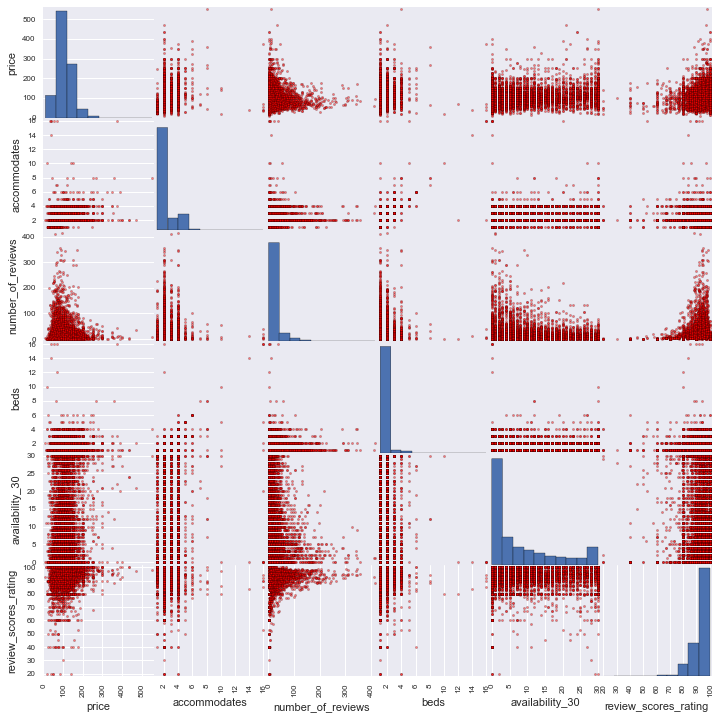

In [15]:
scattercols = ['price','accommodates', 'number_of_reviews', 'reviews_per_month', 'beds', 'availability_30', 
               'review_scores_rating']
axs = pd.scatter_matrix(alldata[scattercols],
                        figsize=(12, 12), c='red')

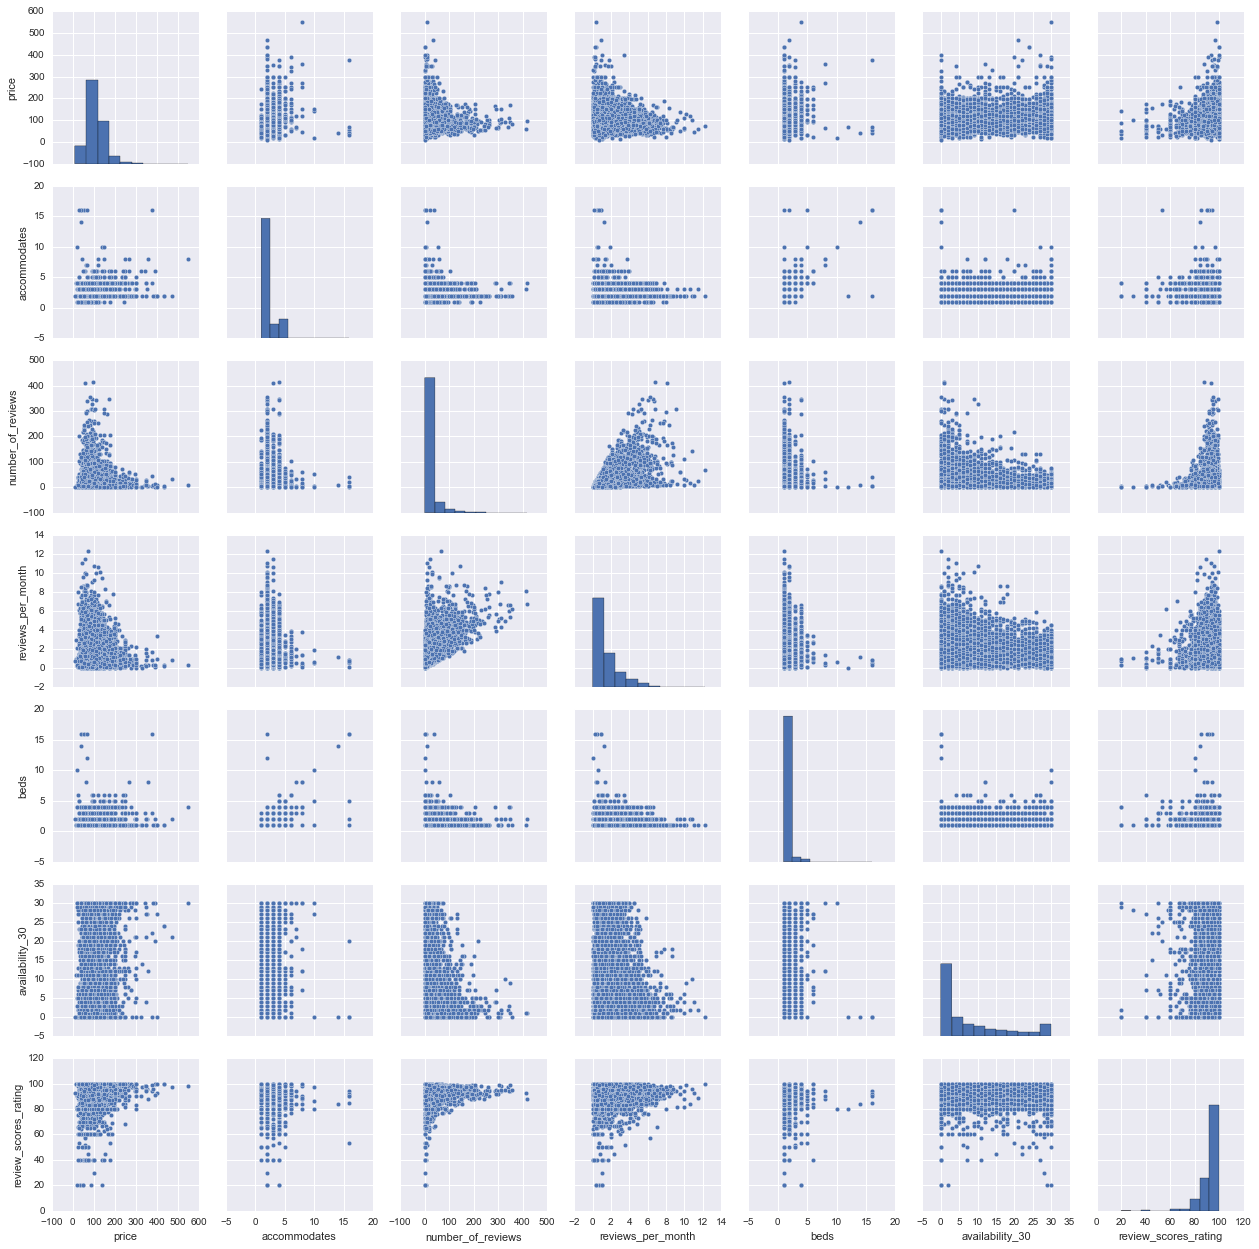

In [17]:
sns.pairplot(alldata[scattercols])

Looking at the output of scatter_matrix, no features show any obvious problems. The most closely related features appear to be 'beds' and 'accommodates'. It's true that the more beds a unit has, the more it accommodates for sleeping, but even these are only loosely related and the result is far from a straight line. Presumably this is because of different bed sizes, sleeping arrangements, and layout of the rental unit.

However, should you not be comfortable, the features while working on your analysis, you could reduce colinearity amongst the features using **Principal Component Analysis (PCA)** on the feature vectors

## Making Predictions with Scikit-Learn and Spark

One of the great things about scikit-learn is that we can easily try a bunch of different linear models on the same data. This will give us some clues as to where we can start tuning. We will start with six of them: vanilla linear regression, ridge and lasso regressions, ElasticNet, bayesian ridge, and a lesser used one called Orthogonal Matching Pursuit.

To evaluate which model(s) are doing better, we will need some way to score the results. In this example I've chosen median absolute error, mainly because it makes sense at a glance (it easily translates to a dollar amount relative to price) and is less sensitive to outliers than other metrics like mean squared error.

Speaking of which, it is fairly likely that we have some outliers in the data since we haven't done any filtering or clustering for them, so this is a good way to get a quick and dirty measure of performance before we move to fine-tuning (and of course, we could do more with outliers in the data preparation step).

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


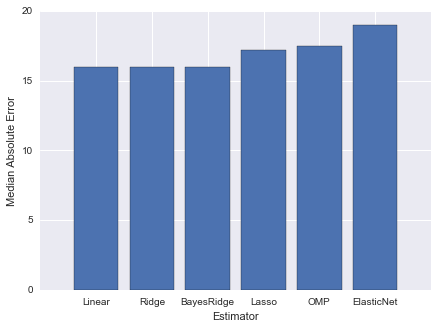

In [16]:
ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP'])
errvals = np.array([])

X_train, X_test, y_train, y_test = train_test_split(alldata.drop(['price'], axis=1),
                                                    alldata.price, test_size=0.2, random_state=20)

for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    #print "got error %0.2f" % this_err
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

Looking at the error from each of these six estimators, they appear to be roughly the same with most of the estimators being able to predict the price with a median error around 16-20 dollars, with BayesRidge coming out on top by a small margin. Having the results be this close isn't surprising, because we haven't done any tuning. The results give us a good general idea of where we stand with the individual estimators.

Next we'll try an ensemble method to see if we can get better results. The upside is that we will likely get a better score, and the downside is that the ensemble methods have a bewildering variety of hyperparameters that must be tuned, each of which can affect our model and requires some experimentation to get right. The common way to approach this is to use an exhaustive "grid search" which simply tries all the supplied parameter combinations and uses cross-validation folding to find the best one. Scikit-learn provides the very handy GridSearchCV function for this purpose.
The tradeoff of using GridSearchCV is that the exhaustive search and cross-validation can take a lot of CPU and time. This is where we can use Spark to distribute the search to more machines and cores, enabling us to test more combinations faster.

For our first attempt, we'll limit the number of parameters just so we can get the results back quickly and see if we're doing better than any of the individual methods above.

In [17]:
n_est = 300


tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.01 ],
    "min_samples_split" : [ 1 ],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
        scoring='median_absolute_error')
preds = clf.fit(X_train, y_train)
best = clf.best_estimator_
best

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.01,
             loss='lad', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=1,
             min_weight_fraction_leaf=0.0, n_estimators=300,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [18]:
abs(clf.best_score_)

15.724435688303439

The result of this attempt is a median error of $15.74.

Already, it looks like we're doing better with GradientBoostingRegressor than we were with any of the prior attempts. Without doing any tuning, the median error is around 20% less than the best error of the previous group (with BayesRidge()).

Let's get a quick measure of how the error is affected by each round of boosting, so we can see if throwing more iterations at the problem is going to help.

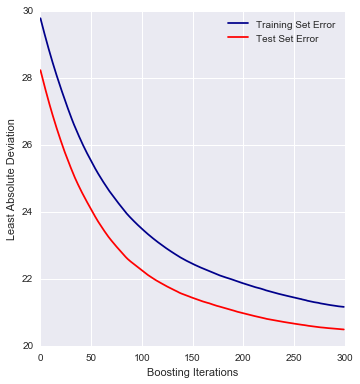

In [19]:
# plot error for each round of boosting
test_score = np.zeros(n_est, dtype=np.float64)

train_score = best.train_score_
for i, y_pred in enumerate(best.staged_predict(X_test)):
    test_score[i] = best.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_est), train_score, 'darkblue', label='Training Set Error')
plt.plot(np.arange(n_est), test_score, 'red', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Least Absolute Deviation')

It looks like the curve is flattening near the right side of the plot (after around 200-250 iterations), but is still benefitting from more iterations, so we could increase the iterations to 500 without much thought.

Now we can do some tuning with GridSearchCV and explore more of the hyperparameter combinations. However, this requires some serious CPU and a complete run of all of the combinations can easily take hours to finish, even on a small number of rows.

### To do the next step, please install spark_sklearn package from Databricks
By simply replacing the following lines in our file, we can use the new spark-sklearn integration package. This allows us to test more hyperparameter combinations, ultimately reducing error, and we can do it all in less time. This will perform more excellently depending on the size of your cluster

    from pyspark import SparkContext, SparkConf
    from spark_sklearn import GridSearchCV

    conf = SparkConf()

    sc = SparkContext(conf=conf)

    clf = GridSearchCV(sc, gbr, cv=3, param_grid=tuned_parameters, scoring='median_absolute_error')

Finally let's look at the feature importances to see which features were most influential in predicting the listing price. This will show us a relative scoring of how important each feature is relative to the feature with the most importance.

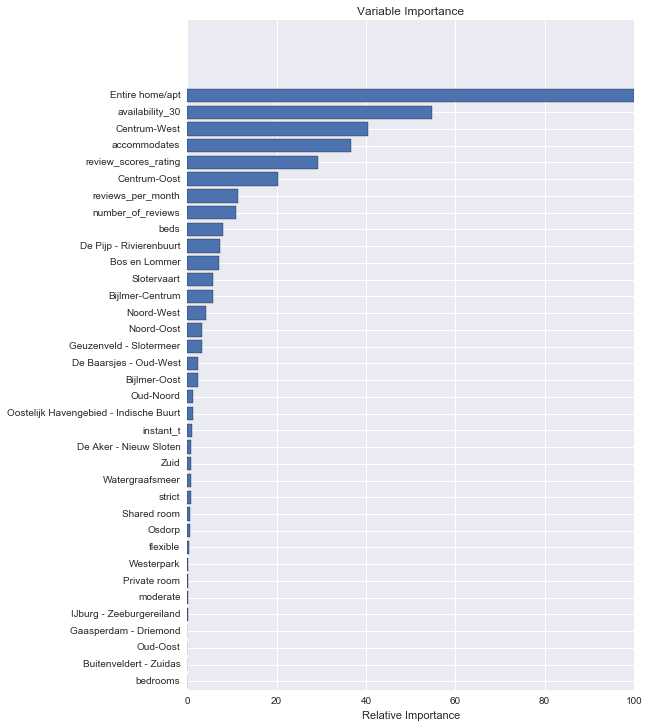

In [20]:

feature_importance = clf.best_estimator_.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(8,12))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

Clearly some of the variables have more influence than others, and the results here are somewhat intuitive. The most influential feature is the 'Entire home/apt' attribute; this indicates whether or not the unit is shared with other people, and has the most effect in setting the price. We would probably expect this feature to be high on the list, and it might be even higher o Reviews are important, as is the short-term availability of the unit, and the Centrum-West and Centrum-Oost neighborhood features also scored high.

You could apply **PCA** to reduce the feature vectors and possibly have better predictions

### Conclusions
In this example we looked at how to predict the price using multiple factors, then scale-out our cross validation and hyperparameter search across a MapR cluster using Spark. We learned the following key points:
In this case, the ensemble method we tried (GradientBoostingRegressor) had better results than any individual estimator.

With GridSearchCV, we tested more hyperparameter combinations that ultimately led us to a better result.

Using [a spark-sklearn](https://github.com/databricks/spark-sklearn) is a straightforward way to throw more CPU at any machine learning problem you might have. We used the package to reduce the time spent searching and reduce the error for our estimator.

There are many ways in which our first-pass analysis could be improved. For example, we might start including more of the data from Inside Airbnb. We could do sentiment analysis on the text of the reviews, bringing this in as an additional feature.

Later we could try out a simple classifier or an essemble model 

*Happy Doing Data*

***Olalekan Elesin***